# Dataset Preparation for training your own object detection model from video recordings 

This notebook walk you through the steps to prepare a dataset for training your own object detection model in Amazon SageMaker using Amazon SageMaker Ground Truth and a series of Python scripts which: 

1. Extracts frames from video and uploads to s3
1. Generates SageMaker Ground Truth Labeling manifest
1. Visualize the SageMaker Ground Truth labeling job manifest
1. Submit Ground Truth labeling job


## Setup

Before we get started, install python dependencies

In [1]:
!pip install -r ./requirements.txt


You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Create a `tmp/` working directory

In [2]:
WORKDING_DIR='tmp/'

In [3]:
!mkdir $WORKDING_DIR # Create a working directory of where the frames will be stored 

Designate a s3 bucket in your AWS account for storing outputs

In [ ]:
OUTPUT_S3_BUCKET = <please replace with your s3 bucket name>

In [20]:
OUTPUT_S3_BUCKET = 'angelaw-blog-throwaway'

## Capture video 

If you would like to capture your own video using your laptop and a webcam, you can use run this script on your laptop to help you do so

```
git clone https://github.com/aws-samples/amazon-sagemaker-aws-greengrass-custom-object-detection-model.git
cd amazon-sagemaker-aws-greengrass-custom-object-detection-model/
pip install -r data-prep/requirements.txt
python data-prep/00_get_video.py -n <name-of-video> -c <camera-id>
```

See the help on the script for what the options do: 
```
python data-prep/00_get_video.py -h
```

## Extract frames from video

Now that we have collected some videos, individual frames need to be extracted from them so they can be labeled and used for training

Use the below video if you would like to follow along using the sample videos we have captured. Or replace it with the S3 location of your own video

In [6]:
VIDEO_S3_BUCKET = 'greengrass-object-detection-blog'
VIDEO_S3_KEY = 'videos/blue_box_1.mp4'

In [9]:
%run -i ./01_video_to_frame_utils.py --video_s3_bucket $VIDEO_S3_BUCKET --video_s3_key $VIDEO_S3_KEY --working_directory $WORKDING_DIR --visualize_video True --visualize_sample_rate 1 -o $OUTPUT_S3_BUCKET

INFO:__main__:video to convert: s3://greengrass-object-detection-blog/videos/blue_box_1.mp4
INFO:__main__:storing files at: tmp/
INFO:__main__:upload frames to S3: False
INFO:__main__:Will generate visualization for video sampling every 1 seconds and upload to s3://greengrass-object-detection-blog/previews/video/
INFO:__main__:Start processing videos/blue_box_1.mp4
INFO:__main__:Frames per second using video.get(cv2.CAP_PROP_FPS) : 5.0
INFO:__main__:created tmp/blue_box_1 folder for frames
INFO:__main__:written 335 frames for blue_box_1.mp4
INFO:__main__:Finished converting video to frames. Took     9.4752 seconds
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
INFO:__main__:Stored preview at tmp/blue_box_1-preview.png. took    13.1849 seconds.
INFO:__main__:uploaded preview to 

The frames are stored at tmp/blue_box_1. You can use tools like s3 sync to upload them to S3. 


In [11]:
!ls -al $WORKDING_DIR/

total 2236
drwxrwxr-x 3 ec2-user ec2-user    4096 Jul 17 17:53 .
drwxrwxr-x 5 ec2-user ec2-user    4096 Jul 17 17:54 ..
drwxrwxr-x 2 ec2-user ec2-user   20480 Jul 17 17:53 blue_box_1
-rw-rw-r-- 1 ec2-user ec2-user 2259319 Jul 17 17:53 blue_box_1-preview.png


In [25]:
video_name='blue_box_1'

### Frame extraction tip #1: Prefix extracted frames with class annotation
During data labeling using Amazon SageMaker Ground Truth for object detection, the worker typically need to select the class the object belongs to in addition to drawing the bounding box. However, if you collected your videos similar to our process, then we already have the class information! When we recorded ourselves moving objects, we already knew what the product is and can add it to the prefix of the video file name. During frame extraction, we can carry that product name over to the image file names, which gives you a free class annotation!  

In [26]:
!ls -al $WORKDING_DIR/$video_name | head

total 143768
drwxrwxr-x 2 ec2-user ec2-user  20480 Jul 17 17:53 .
drwxrwxr-x 3 ec2-user ec2-user   4096 Jul 17 17:53 ..
-rw-rw-r-- 1 ec2-user ec2-user 338470 Jul 17 17:53 blue_box_1_000000.jpg
-rw-rw-r-- 1 ec2-user ec2-user 505372 Jul 17 17:53 blue_box_1_000001.jpg
-rw-rw-r-- 1 ec2-user ec2-user 535266 Jul 17 17:53 blue_box_1_000002.jpg
-rw-rw-r-- 1 ec2-user ec2-user 552473 Jul 17 17:53 blue_box_1_000003.jpg
-rw-rw-r-- 1 ec2-user ec2-user 557837 Jul 17 17:53 blue_box_1_000004.jpg
-rw-rw-r-- 1 ec2-user ec2-user 561186 Jul 17 17:53 blue_box_1_000005.jpg
-rw-rw-r-- 1 ec2-user ec2-user 564393 Jul 17 17:53 blue_box_1_000006.jpg
ls: write error: Broken pipe


### Frame extraction Tip #2: Review contents of your extracted frames for image quality, PII, confidential data, and background-only images

There are several reasons to generate and review the thumbnail of the frames you collected at this stage, including to: 
* Verify if the quality of the image/field of vision captures your use case you are trying solve: if not, retake the video. 
* Confirm whether the frames contain Personally Identifiable Information (PII): if yes, consider either filtering out the frames containing PII or choosing only a private workforce to label your data.  
* Determine whether the frames contain any company confidential information: if yes, either redact/filter out the confidential information, or choosing only a private workforce to label your data.  
* Decide if there are too many “empty” frames (ie. background only) that don't contain the objects you are trying to detect. If so, we recommend adding a processing step to remove these background images. The reason for this is object detection algorithms usually require training data that actually contains the target objects (there may be exceptions). Data labeling services, such as SageMaker Ground Truth, charge by number of images labeled. Therefore, you can achieve some cost savings if you pre-filter background images before you submit them for bounding box labeling. To filter out background images automatically, we've found success in past projects using a pre-trained image classifier such as Amazon Recognition, or use color histogram similarity functions (https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_comparison/histogram_comparison.html) provided by OpenCV. Creating a image classification job in SageMaker Ground Truth (cheaper than bounding box labeling) can be another option. 

As part of the `01_video_to_frame_utils.py` script, a thumbnail image of the frames is generated so you can easily review for the above. You can review the command line options of the script on configurations for this feature (e.g. how frequently to sample frames for thumbnail generation).

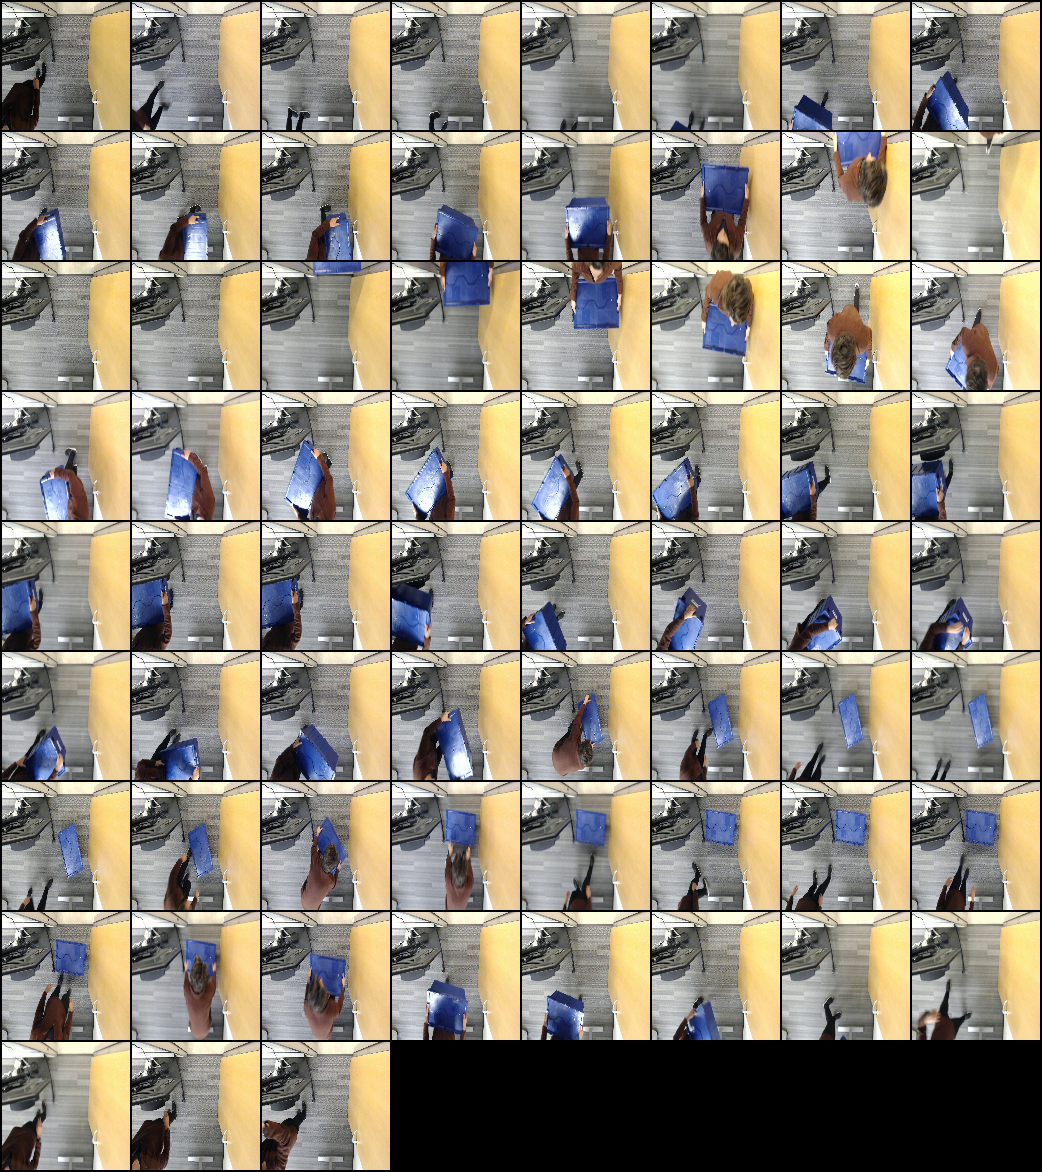

In [27]:
from IPython.display import Image
Image(filename=f'{WORKDING_DIR}/{video_name}-preview.png') 

## Upload extracted frames to S3 
The above script extracts every single frame from the video into the working directory. We may not want to have every frame labeled by Ground Truth workers, however, it's good to store a copy of all the frames into S3 for future use

In [28]:
!aws s3 sync $WORKDING_DIR/$folder_name s3://$OUTPUT_S3_BUCKET/frames/ --quiet